In [1]:
# Nacitanie kniznic.
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import albumentations as alb
import cv2



C:\Users\Lukas-novy-pc\anaconda3\envs\test-env\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.7 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Nastavenie globalnych konstatnt.
IMG_SIZE = 256   # Nastavenie velkosti vsetkych obrazkov.
BATCH_SIZE = 32 # Nastavenie velkosti batch.
SEED = 42       # Nastavenie seedu.
EPOCHS = 200    # Nastavenie poctu epoch.

In [3]:
# Priprava dat na trenovanie.

NUM_CLASSES = 3
DATA_DIR = r'C:\Users\Lukas-novy-pc\Downloads\BU_data_training_sample\BU_data_training_sample'

CATEGORIES = ['0_cloudy', '1_partly', '2_clear']

img_list = []
class_list = []
for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    class_num = CATEGORIES.index(category)
    images = [x for x in os.listdir(path) if ".DS_Store" not in x]
    np.random.shuffle(images) # Nahodne zamiesanie obrazkov.
    num_images = len(images)
    for img in images[:num_images]:
        # Otvorenie obrazku, orezanie okrajov, a zmena velkosti pre lahsie trenovanie.
        img_array = np.array(Image.open(os.path.join(path, img)).crop((100, 100, 582, 582)).resize((IMG_SIZE, IMG_SIZE)))
        img_list.append(img_array)
        class_list.append(class_num)

    print(f'Number of images in class {class_num}: {num_images}')

# Normalizacia dat: z (0; 255) na (0; 1).
X = np.asarray(img_list, dtype=np.float32) / 255.0
y = np.asarray(class_list)

# Zmena tvaru na (n_imgs, height, width, channels).
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)


Number of images in class 0: 1118
Number of images in class 1: 1316
Number of images in class 2: 1718


In [4]:
# Rozdelenie dat na trenovaciu, validacnu a testovaciu mnozinu.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=SEED, shuffle=True)

print("train distribution: ", np.unique(y_train,return_counts=True))
print("val distribution: ", np.unique(y_val,return_counts=True))
print("test distribution: ", np.unique(y_test,return_counts=True))

y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"Tréningová sada: {X_train.shape}")
print(f"Validačná sada: {X_val.shape}")
print(f"Testovacia sada: {X_test.shape}")

print('Data are prepared for training')

train distribution:  (array([0, 1, 2]), array([ 790,  929, 1269], dtype=int64))
val distribution:  (array([0, 1, 2]), array([ 81, 114, 138], dtype=int64))
test distribution:  (array([0, 1, 2]), array([247, 273, 311], dtype=int64))
Tréningová sada: (2988, 256, 256, 1)
Validačná sada: (333, 256, 256, 1)
Testovacia sada: (831, 256, 256, 1)
Data are prepared for training


In [5]:
# Datova augmentacia (vertikalne a horizontalne prevratenie a rozacia obrazka).
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=45)
datagen.fit(X_train)

In [7]:
# Model rozhodovacieho stromu.
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
import numpy as np

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("Defining model...")
clf = DecisionTreeClassifier(max_depth=10, random_state=42)

print("Training model...")
clf.fit(X_train_flat, y_train_labels)

print("Evaluating on validation set...")
y_val_pred = clf.predict(X_val_flat)
y_val_pred_proba = clf.predict_proba(X_val_flat)  # Pravdepodobnosti pre log_loss.

val_accuracy = accuracy_score(y_val_labels, y_val_pred)
val_loss = log_loss(y_val_labels, y_val_pred_proba)  # Výpočet validačnej straty.

print(f"Presnosť na validačnej množine: {val_accuracy:.2f}")
print(f"Strata (val_loss) na validačnej množine: {val_loss:.4f}")

# Vyhodnotenie na testovacej množine.
print("Evaluating on test set...")
y_test_pred = clf.predict(X_test_flat)
print("Klasifikačný report na testovacej množine:")
print(classification_report(y_test_labels, y_test_pred, target_names=['cloudy', 'partly', 'clear']))

test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Presnosť na testovacej množine: {test_accuracy:.2f}")


Defining model...
Training model...
Evaluating on validation set...
Presnosť na validačnej množine: 0.70
Strata (val_loss) na validačnej množine: 5.8115
Evaluating on test set...
Klasifikačný report na testovacej množine:
              precision    recall  f1-score   support

      cloudy       0.83      0.77      0.79       247
      partly       0.55      0.50      0.52       273
       clear       0.64      0.72      0.68       311

    accuracy                           0.66       831
   macro avg       0.67      0.66      0.66       831
weighted avg       0.66      0.66      0.66       831

Presnosť na testovacej množine: 0.66


In [8]:
# Vytvorenie matice zamen.
cm1 = confusion_matrix(y_test_labels, y_test_pred)
print("Confusion matrix:\n", cm1)

Confusion matrix:
 [[189  39  19]
 [ 27 136 110]
 [ 13  73 225]]


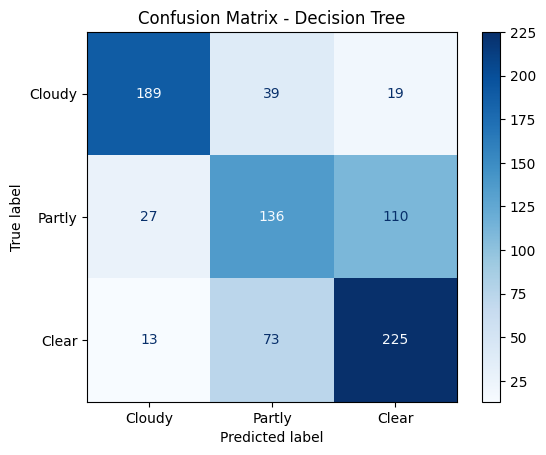

In [9]:
# Vykreslenie a ulozenie matice zamen.
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd1 = ConfusionMatrixDisplay(cm1, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd1.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - Decision Tree")

# Uloženie do súboru
plt.savefig("confusion_matrix_decision_tree.png", dpi=300, bbox_inches='tight')

plt.show()


In [10]:
# Vytvorenie modelu nahodneho lesa.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss
import numpy as np


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Defining model...")
clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)

# Trénovanie modelu.
print("Training model...")
clf.fit(X_train_flat, y_train_labels)


print("Evaluating on validation set...")
y_val_pred = clf.predict(X_val_flat)
y_val_pred_proba = clf.predict_proba(X_val_flat)  
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
val_loss = log_loss(y_val_labels, y_val_pred_proba)  
print(f"Presnosť na validačnej množine: {val_accuracy:.2f}")
print(f"Strata (val_loss) na validačnej množine: {val_loss:.4f}")

# Vyhodnotenie na testovacej množine.
print("Evaluating on test set...")
y_test_pred = clf.predict(X_test_flat)
print("Klasifikačný report na testovacej množine:")
print(classification_report(y_test_labels, y_test_pred, target_names=['cloudy', 'partly', 'clear']))

test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Presnosť na testovacej množine: {test_accuracy:.2f}")


Defining model...
Training model...
Evaluating on validation set...
Presnosť na validačnej množine: 0.81
Strata (val_loss) na validačnej množine: 0.4900
Evaluating on test set...
Klasifikačný report na testovacej množine:
              precision    recall  f1-score   support

      cloudy       0.97      0.91      0.94       247
      partly       0.81      0.60      0.69       273
       clear       0.73      0.93      0.82       311

    accuracy                           0.82       831
   macro avg       0.84      0.81      0.82       831
weighted avg       0.83      0.82      0.81       831

Presnosť na testovacej množine: 0.82


In [11]:
# Vytvorenie matice zamen.
cm2 = confusion_matrix(y_test_labels, y_test_pred)
print("Confusion matrix:\n", cm2)

Confusion matrix:
 [[225  16   6]
 [  8 165 100]
 [  0  22 289]]


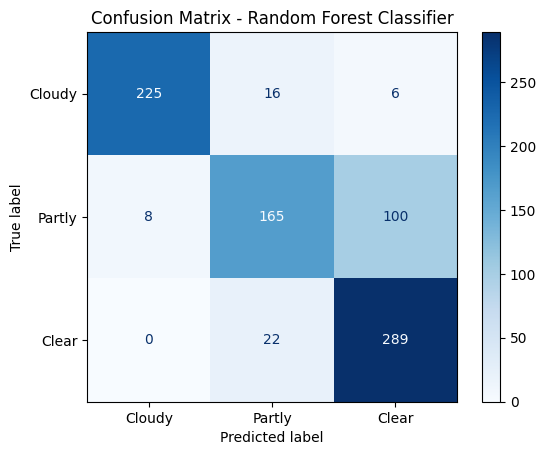

In [12]:
# Vykreslenie a ulozenie matice zamen.
cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd2.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - Random Forest Classifier")

plt.savefig("confusion_matrix_forest_classifier.png", dpi=300, bbox_inches='tight')


plt.show()

In [13]:
# Vytvorenie modelu logistickej regresie.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
import numpy as np

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Definovanie modelu logistickej regresie.
print("Defining model...")
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)

# Trénovanie modelu.
print("Training model...")
clf.fit(X_train_flat, y_train_labels)

# Vyhodnotenie na validačnej množine
print("Evaluating on validation set...")
y_val_pred = clf.predict(X_val_flat)
y_val_pred_proba = clf.predict_proba(X_val_flat)  # Pravdepodobnosti pre log_loss.

val_accuracy = accuracy_score(y_val_labels, y_val_pred)
val_loss = log_loss(y_val_labels, y_val_pred_proba)  # Výpočet validačnej straty.

print(f"Presnosť na validačnej množine: {val_accuracy:.2f}")
print(f"Strata (val_loss) na validačnej množine: {val_loss:.4f}")

# Vyhodnotenie na testovacej množine.
print("Evaluating on test set...")
y_test_pred = clf.predict(X_test_flat)
print("Klasifikačný report na testovacej množine:")
print(classification_report(y_test_labels, y_test_pred, target_names=['cloudy', 'partly', 'clear']))

test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Presnosť na testovacej množine: {test_accuracy:.2f}")

Defining model...
Training model...


C:\Users\Lukas-novy-pc\anaconda3\envs\test-env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating on validation set...
Presnosť na validačnej množine: 0.79
Strata (val_loss) na validačnej množine: 0.6070
Evaluating on test set...
Klasifikačný report na testovacej množine:
              precision    recall  f1-score   support

      cloudy       0.90      0.91      0.90       247
      partly       0.67      0.59      0.62       273
       clear       0.73      0.80      0.76       311

    accuracy                           0.76       831
   macro avg       0.76      0.76      0.76       831
weighted avg       0.76      0.76      0.76       831

Presnosť na testovacej množine: 0.76


In [14]:
# Vytvorenie matice zamen.
cm3 = confusion_matrix(y_test_labels, y_test_pred)
print("Confusion matrix:\n", cm3)

Confusion matrix:
 [[224  20   3]
 [ 24 160  89]
 [  2  60 249]]


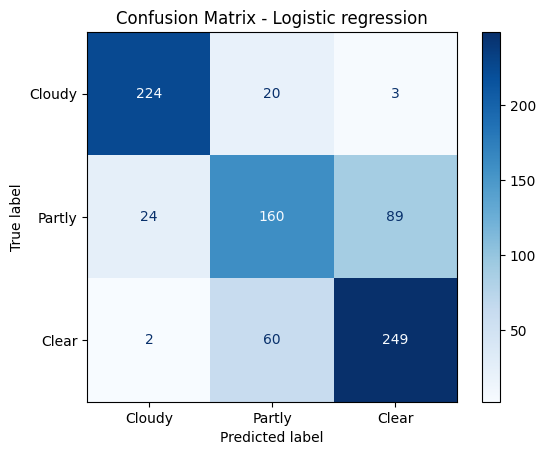

In [15]:
# Vykreslenie a ulozenie matice zamen.
cmd3 = ConfusionMatrixDisplay(cm3, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd3.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - Logistic regression")

plt.savefig("confusion_matrix_logistic_regression.png", dpi=300, bbox_inches='tight')

plt.show()

In [18]:
# Architektura modelu A32,64.
model_filename = 'A32,64.keras'
callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=30)


print('Defining model...')
model = Sequential() 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:])) # Pridanie konvolucnej vrstvy s velkostou filtra 3x3.
model.add(MaxPooling2D()) # Pridanie maxpooling vrstvy.
model.add(Dropout(0.2)) # Pridanie dropout vrstvy - vypina nahodne 20% neuronov pocas trenovania.

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Defining model...


In [19]:
# Spustenie trenovania a ukladanie historie trenovania.
print('Training model...')
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=[callback_checkpoint, early_stopping])


Training model...
Epoch 1/200
94/94 [==============================] - ETA: 0s - loss: 1.6284 - accuracy: 0.4006
Epoch 1: val_loss improved from inf to 1.07228, saving model to A32,64.keras
94/94 [==============================] - 6s 58ms/step - loss: 1.6284 - accuracy: 0.4006 - val_loss: 1.0723 - val_accuracy: 0.4144
Epoch 2/200
94/94 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.4247
Epoch 2: val_loss improved from 1.07228 to 1.05744, saving model to A32,64.keras
94/94 [==============================] - 5s 56ms/step - loss: 1.0728 - accuracy: 0.4247 - val_loss: 1.0574 - val_accuracy: 0.4144
Epoch 3/200
94/94 [==============================] - ETA: 0s - loss: 1.0608 - accuracy: 0.4277
Epoch 3: val_loss improved from 1.05744 to 1.05095, saving model to A32,64.keras
94/94 [==============================] - 5s 57ms/step - loss: 1.0608 - accuracy: 0.4277 - val_loss: 1.0509 - val_accuracy: 0.4444
Epoch 4/200
94/94 [==============================] - ETA: 0s - loss:

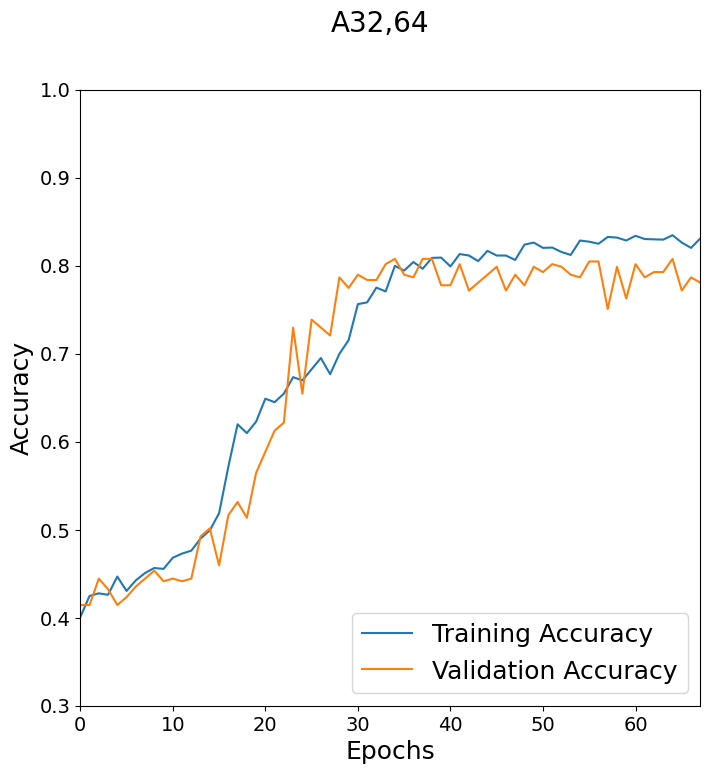

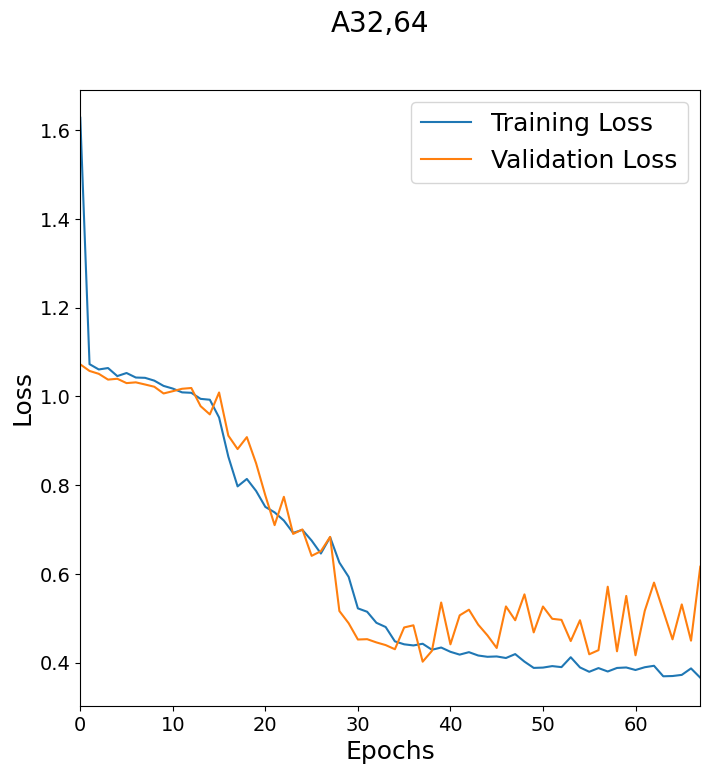

In [26]:
# Plot training accuracy
plt.figure(figsize=(8, 8))

# Vykreslenie presnosti na trénovacej a validačnej množine
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Rozsahy osí
plt.xlim([0, history.epoch[-1]])
plt.ylim([0.3, 1])

# Legenda v pravom dolnom rohu
plt.legend(loc='lower right', fontsize=18)

# Nadpis nad obrázkom
plt.suptitle('A32,64', fontsize=20)
plt.grid()

# Uloženie grafu
plt.savefig('training_accuracy_A32_64.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training loss
plt.figure(figsize=(8, 8))

# Vykreslenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Orezanie osí podľa potreby
plt.xlim([0, history.epoch[-1]])

# Legenda hore vpravo
plt.legend(loc='upper right', fontsize=18)

# Nadpis nad grafom
plt.suptitle('A32,64', fontsize=20)
plt.grid()

# Uloženie grafu
plt.savefig('training_loss_A32_64.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# Vyhodnotenie modelu.
model = tf.keras.models.load_model(model_filename)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Vypocitanie zakladnych metrik pre vyhodnotenie.
cr4 = classification_report(np.argmax(y_test, axis=1), y_pred)
print('Classification Report\n', cr4)

# Vytvorenie matice zamen.
cm4 = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print('Confusion matrix:\n', cm4)

26/26 [==============================] - 0s 13ms/step - loss: 0.4185 - accuracy: 0.8014
Test accuracy: 0.8014440536499023
26/26 [==============================] - 0s 8ms/step
Classification Report
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       247
           1       0.86      0.48      0.62       273
           2       0.68      0.96      0.80       311

    accuracy                           0.80       831
   macro avg       0.84      0.80      0.79       831
weighted avg       0.83      0.80      0.79       831

Confusion matrix:
 [[236  10   1]
 [  4 131 138]
 [  0  12 299]]


In [22]:
# Predikovanie na testovacich datach.
y_pred = model.predict(X_test)
y_pred

26/26 [==============================] - 0s 8ms/step


array([[2.4740975e-03, 9.7559321e-01, 2.1932727e-02],
       [9.0357624e-09, 8.8196561e-02, 9.1180342e-01],
       [1.2458410e-12, 9.9461496e-02, 9.0053850e-01],
       ...,
       [7.1291978e-12, 9.3917780e-02, 9.0608221e-01],
       [1.5356592e-10, 2.8417388e-01, 7.1582609e-01],
       [9.6676725e-13, 3.4678876e-02, 9.6532112e-01]], dtype=float32)

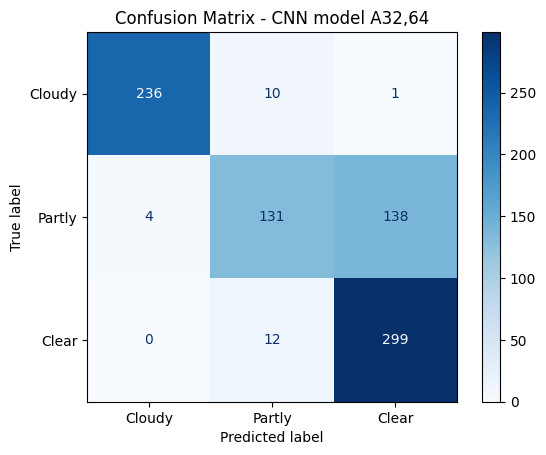

In [24]:
# Vykreslenie a ulozenie matice zamen.

cmd4 = ConfusionMatrixDisplay(cm4, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd4.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - CNN model A32,64")
plt.savefig("confusion_matrix_CNN model_A32,64.png", dpi=300, bbox_inches='tight')

plt.show()

In [27]:
# Vypisanie architektury modelu.
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 64)       

In [5]:
# # Architektura modelu B32,64,128.
EPOCHS = 300 # Nastavenie poctu epoch na 300
model_filename = 'B32,64,128.keras'
callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

print('Defining model...')

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Defining model...


In [38]:
# Spustenie trenovania a ukladanie historie trenovania.
print('Training model...')
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=[callback_checkpoint, early_stopping])


Training model...
Epoch 1/300
93/94 [============================>.] - ETA: 0s - loss: 1.3523 - accuracy: 0.4141
Epoch 1: val_loss improved from inf to 1.07794, saving model to B32,64,128.keras
94/94 [==============================] - 6s 57ms/step - loss: 1.3493 - accuracy: 0.4147 - val_loss: 1.0779 - val_accuracy: 0.4144
Epoch 2/300
94/94 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.4575
Epoch 2: val_loss improved from 1.07794 to 0.98153, saving model to B32,64,128.keras
94/94 [==============================] - 5s 56ms/step - loss: 1.0440 - accuracy: 0.4575 - val_loss: 0.9815 - val_accuracy: 0.5195
Epoch 3/300
94/94 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.5281
Epoch 3: val_loss improved from 0.98153 to 0.95222, saving model to B32,64,128.keras
94/94 [==============================] - 5s 56ms/step - loss: 0.9581 - accuracy: 0.5281 - val_loss: 0.9522 - val_accuracy: 0.4805
Epoch 4/300
94/94 [==============================] - ETA

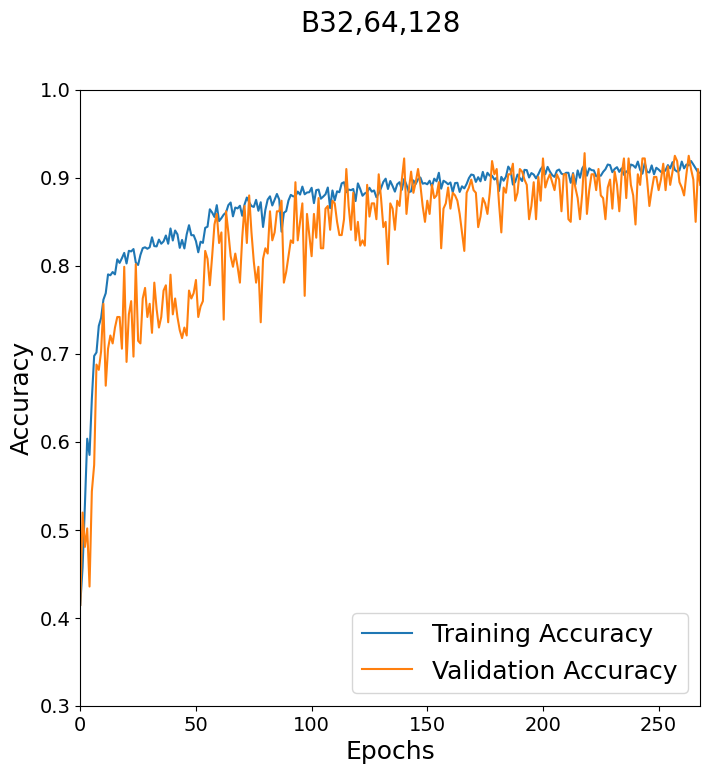

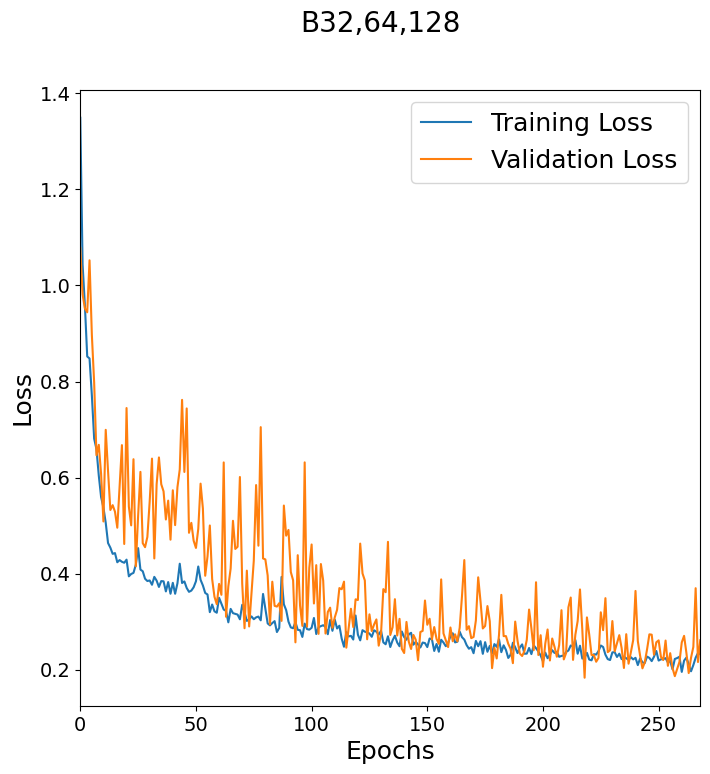

In [39]:
# Plot training accuracy
plt.figure(figsize=(8, 8))

# Vykreslenie presnosti na trénovacej a validačnej množine
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Rozsahy osí
plt.xlim([0, history.epoch[-1]])
plt.ylim([0.3, 1])

# Legenda v pravom dolnom rohu
plt.legend(loc='lower right', fontsize=18)

# Nadpis nad obrázkom
plt.suptitle('B32,64,128', fontsize=20)

# Uloženie grafu
plt.savefig('training_accuracy_B_32_64_128.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training loss
plt.figure(figsize=(8, 8))

# Vykreslenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Orezanie osí podľa potreby
plt.xlim([0, history.epoch[-1]])

# Legenda hore vpravo
plt.legend(loc='upper right', fontsize=18)

# Nadpis nad grafom
plt.suptitle('B32,64,128', fontsize=20)

# Uloženie grafu
plt.savefig('training_loss_B32_64_128.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# Vyhodnotenie modelu.
model = tf.keras.models.load_model(model_filename)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Vypocitanie zakladnych metrik pre vyhodnotenie.
cr5 = classification_report(np.argmax(y_test, axis=1), y_pred)
print('Classification Report\n', cr5)

# Vytvorenie matice zamen.
cm5 = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print('Confusion matrix:\n', cm5)

26/26 [==============================] - 3s 21ms/step - loss: 0.2007 - accuracy: 0.9218
Test accuracy: 0.9217810034751892
26/26 [==============================] - 0s 14ms/step
Classification Report
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       247
           1       0.93      0.82      0.87       273
           2       0.87      0.95      0.91       311

    accuracy                           0.92       831
   macro avg       0.93      0.92      0.92       831
weighted avg       0.92      0.92      0.92       831

Confusion matrix:
 [[246   1   0]
 [  4 225  44]
 [  0  16 295]]


In [7]:
# Predikovanie na testovacich datach.
y_pred = model.predict(X_test)
y_pred

26/26 [==============================] - 0s 12ms/step


array([[9.8277133e-06, 1.6769359e-01, 8.3229655e-01],
       [3.3908813e-07, 4.3907184e-02, 9.5609248e-01],
       [1.0159463e-11, 2.0860982e-01, 7.9139018e-01],
       ...,
       [6.6021123e-08, 4.3169148e-02, 9.5683074e-01],
       [3.4597612e-13, 6.9088066e-01, 3.0911931e-01],
       [3.3467916e-11, 2.1778570e-01, 7.8221422e-01]], dtype=float32)

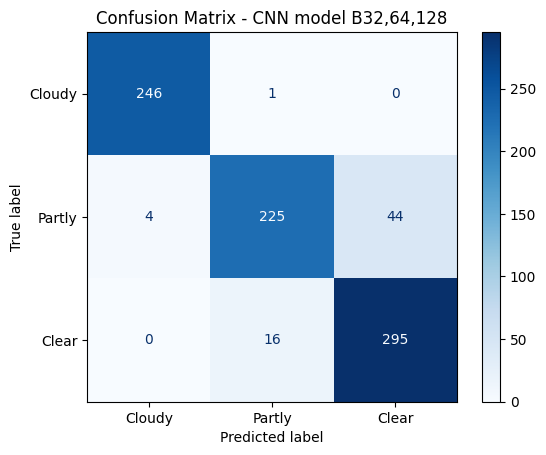

In [8]:
# Vykreslenie a ulozenie matice zamen.
cmd5 = ConfusionMatrixDisplay(cm5, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd5.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - CNN model B32,64,128")
plt.savefig("confusion_matrix_CNN model_B32,64,128.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Vykreslenie nespravne klasifikovanych obrazkov v 2 variantach, farebne a ciernobielo. 
nn=0
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
for i in range(0, len(y_pred)):
    if y_pred[i] != y_true[i]:
        im = X_test[i]
      
        plt.figure(figsize=(8, 4))  
        plt.subplot(1, 2, 1)  
        plt.imshow(im.squeeze())  
        plt.axis('off')  
        plt.title(f'Img: {nn}, True label: {y_true[i]}, Pred: {y_pred[i]}')

        plt.subplot(1, 2, 2)  
        plt.imshow(im.squeeze(), cmap='gray')  
        plt.axis('off') 
        plt.title(f'Img: {nn}, True label: {y_true[i]}, Pred: {y_pred[i]}')

        nn = nn + 1
        plt.tight_layout()  # Zabezpečí, že obrázky nebudú prekrývať.
        plt.show()
## Kedze vykreslenie tychto obrazkov zvacsuje velkost finalneho .ipynb suboru, zmazal som output lebo na github je mozne nahrat subory maximalnej velkosti 25MB.

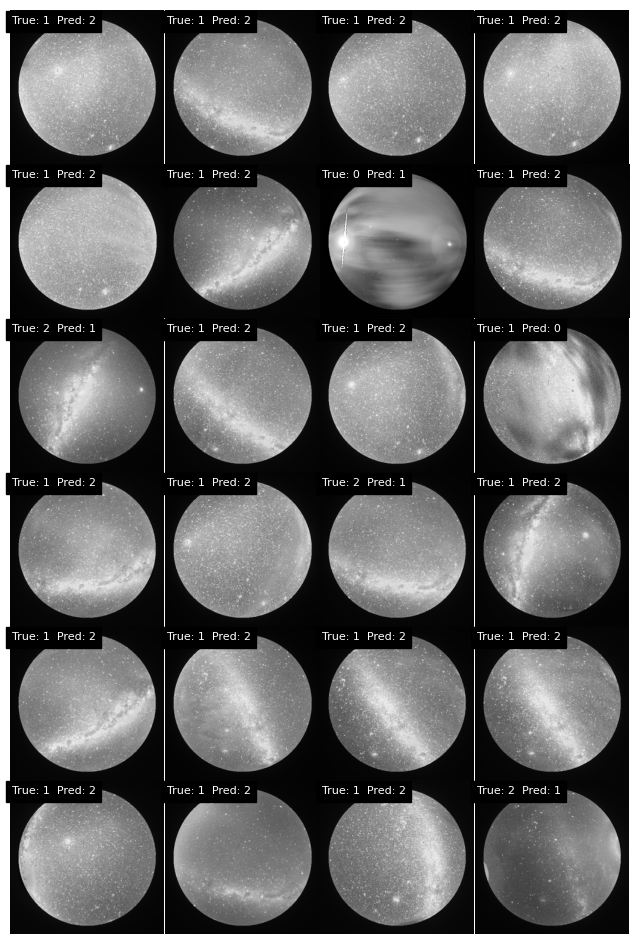

In [17]:
# Vykreslenie a ulozenie obrazka pozostavajuceho z prvych 24 nespravne klasifikovanych obrazkov.
import matplotlib.pyplot as plt
import numpy as np

y_true = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Získať prvých 24 nesprávne klasifikovaných obrázkov.
wrong_indices = np.where(y_pred_labels != y_true)[0][:24]

fig, axes = plt.subplots(6, 4, figsize=(8, 12))

for ax, idx in zip(axes.ravel(), wrong_indices):
    im = X_test[idx]
    ax.imshow(im.squeeze(), cmap='gray')
    # Vložiť text priamo do obrázka (hore vľavo)
    ax.text(
        2, 10,  # pozícia textu v pixeloch (x, y)
        f'True: {y_true[idx]}  Pred: {y_pred_labels[idx]}',
        color='white',
        fontsize=8,
        ha='left',
        va='top',
        backgroundcolor='black'  
    )
    ax.axis('off')

# Odstránrnir medzirer medzi obrázkami.
plt.subplots_adjust(wspace=0, hspace=0)

# Uložiť bez okrajov
plt.savefig("chybne_klasifikacie_24_4x6.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [7]:
# Vypisanie architektury modelu.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

In [57]:
# Architektura modelu C32,64,128,256.
model_filename = 'C32,64,128,256.keras'
callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

print('Defining model...')

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Defining model...


In [58]:
# Spustenie trenovania a ukladanie historie trenovania.
print('Training model...')
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=[callback_checkpoint, early_stopping])


Training model...
Epoch 1/300
94/94 [==============================] - ETA: 0s - loss: 1.1386 - accuracy: 0.4133
Epoch 1: val_loss improved from inf to 1.08298, saving model to C32,64,128,256.keras
94/94 [==============================] - 7s 68ms/step - loss: 1.1386 - accuracy: 0.4133 - val_loss: 1.0830 - val_accuracy: 0.4144
Epoch 2/300
94/94 [==============================] - ETA: 0s - loss: 1.0754 - accuracy: 0.4190
Epoch 2: val_loss improved from 1.08298 to 1.07095, saving model to C32,64,128,256.keras
94/94 [==============================] - 6s 59ms/step - loss: 1.0754 - accuracy: 0.4190 - val_loss: 1.0710 - val_accuracy: 0.4144
Epoch 3/300
94/94 [==============================] - ETA: 0s - loss: 1.0357 - accuracy: 0.4632
Epoch 3: val_loss did not improve from 1.07095
94/94 [==============================] - 5s 56ms/step - loss: 1.0357 - accuracy: 0.4632 - val_loss: 1.0820 - val_accuracy: 0.4144
Epoch 4/300
94/94 [==============================] - ETA: 0s - loss: 0.9827 - accuracy

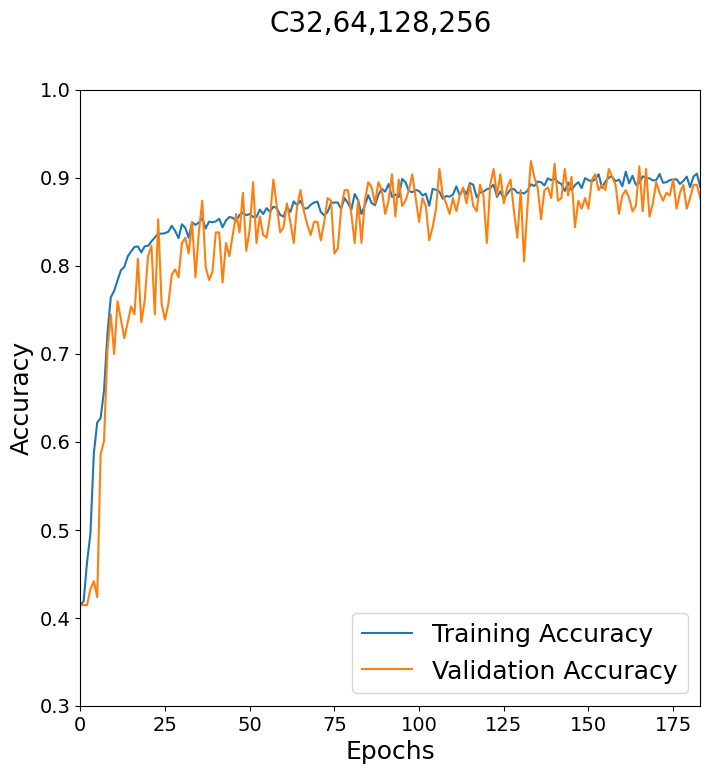

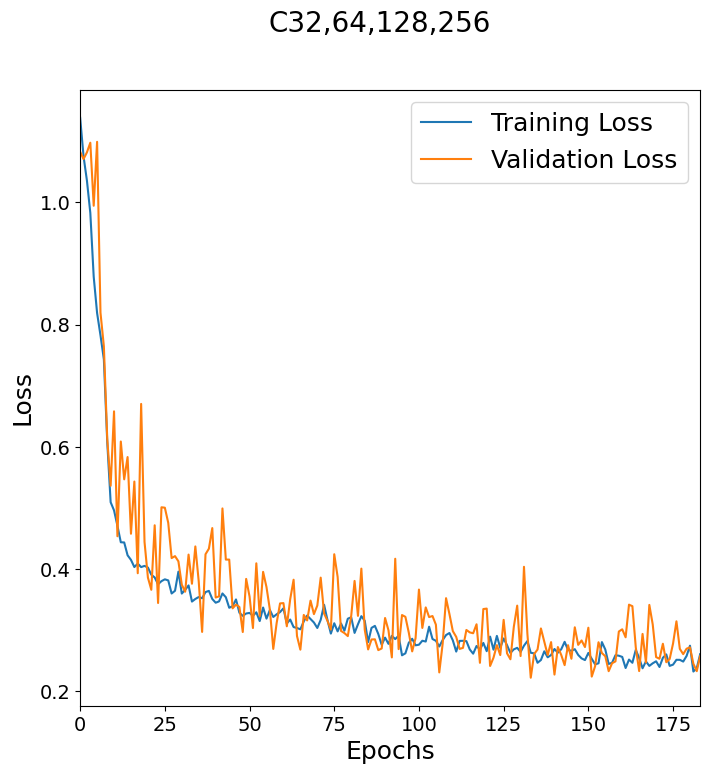

In [59]:
# Plot training accuracy
plt.figure(figsize=(8, 8))

# Vykreslenie presnosti na trénovacej a validačnej množine
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Rozsahy osí
plt.xlim([0, history.epoch[-1]])
plt.ylim([0.3, 1])

# Legenda v pravom dolnom rohu
plt.legend(loc='lower right', fontsize=18)

# Nadpis nad obrázkom
plt.suptitle('C32,64,128,256', fontsize=20)

# Uloženie grafu
plt.savefig('training_accuracy_C32_64_128_256.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training loss
plt.figure(figsize=(8, 8))

# Vykreslenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Orezanie osí podľa potreby
plt.xlim([0, history.epoch[-1]])

# Legenda hore vpravo
plt.legend(loc='upper right', fontsize=18)

# Nadpis nad grafom
plt.suptitle('C32,64,128,256', fontsize=20)

# Uloženie grafu
plt.savefig('training_loss_C32_64_128_256.png', dpi=300, bbox_inches='tight')
plt.show()


In [60]:
# Vyhodnotenie modelu.
model = tf.keras.models.load_model(model_filename)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Vypocitanie zakladnych metrik pre vyhodnotenie.
cr6 = classification_report(np.argmax(y_test, axis=1), y_pred)
print('Classification Report\n', cr6)

# Vytvorenie matice zamen.
cm6 = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print('Confusion matrix:\n', cm6)

26/26 [==============================] - 1s 15ms/step - loss: 0.2537 - accuracy: 0.8953
Test accuracy: 0.8953068852424622
26/26 [==============================] - 0s 9ms/step
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       247
           1       0.89      0.78      0.83       273
           2       0.84      0.93      0.88       311

    accuracy                           0.90       831
   macro avg       0.90      0.90      0.90       831
weighted avg       0.90      0.90      0.89       831

Confusion matrix:
 [[242   5   0]
 [  3 213  57]
 [  0  22 289]]


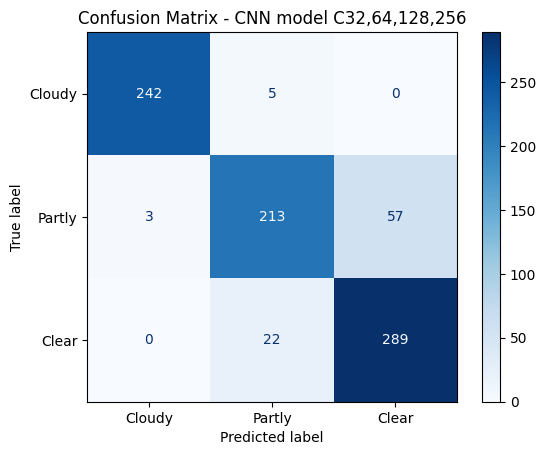

In [61]:
# Vykreslenie a ulozenie matice zamen.
cmd6 = ConfusionMatrixDisplay(cm6, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd6.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - CNN model C32,64,128,256")
plt.savefig("confusion_matrix_CNN model_C32,64,128,256.png", dpi=300, bbox_inches='tight')

plt.show()

In [15]:
# Vypisanie architektury modelu.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 62, 62, 64)       

In [6]:
# Architektura modelu D16,32,64,128.
EPOCHS = 300
model_filename = 'D16,32,64,128.keras'
callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

print('Defining model...')

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D())
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Defining model...


In [7]:
# Spustenie trenovania a ukladanie historie trenovania.
print('Training model...')
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=[callback_checkpoint, early_stopping])


Training model...
Epoch 1/300
94/94 [==============================] - ETA: 0s - loss: 1.1185 - accuracy: 0.4157
Epoch 1: val_loss improved from inf to 1.07779, saving model to D16,32,64,128.keras
94/94 [==============================] - 10s 57ms/step - loss: 1.1185 - accuracy: 0.4157 - val_loss: 1.0778 - val_accuracy: 0.4144
Epoch 2/300
94/94 [==============================] - ETA: 0s - loss: 1.0768 - accuracy: 0.4257
Epoch 2: val_loss improved from 1.07779 to 1.06711, saving model to D16,32,64,128.keras
94/94 [==============================] - 5s 52ms/step - loss: 1.0768 - accuracy: 0.4257 - val_loss: 1.0671 - val_accuracy: 0.4144
Epoch 3/300
94/94 [==============================] - ETA: 0s - loss: 1.0176 - accuracy: 0.4685
Epoch 3: val_loss improved from 1.06711 to 1.04483, saving model to D16,32,64,128.keras
94/94 [==============================] - 5s 52ms/step - loss: 1.0176 - accuracy: 0.4685 - val_loss: 1.0448 - val_accuracy: 0.4144
Epoch 4/300
94/94 [===========================

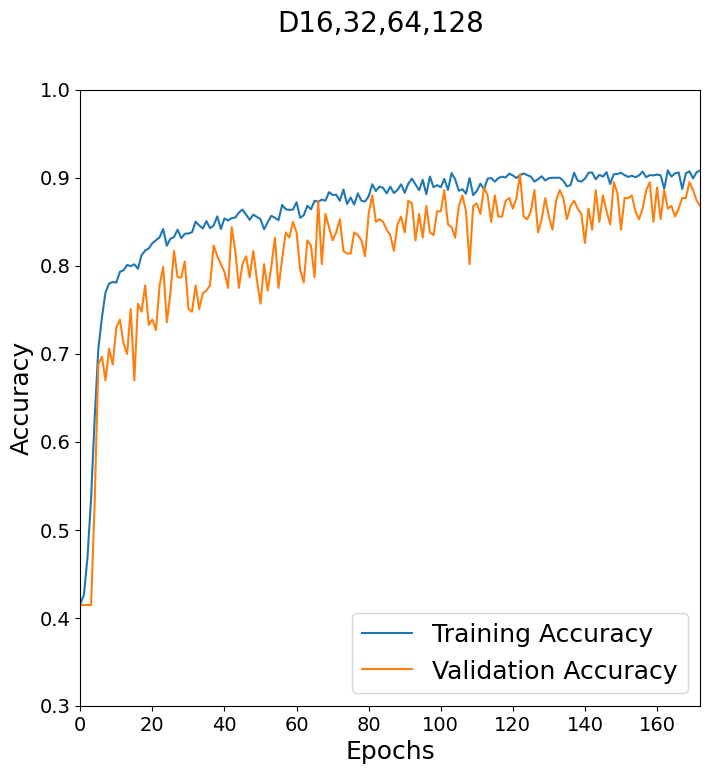

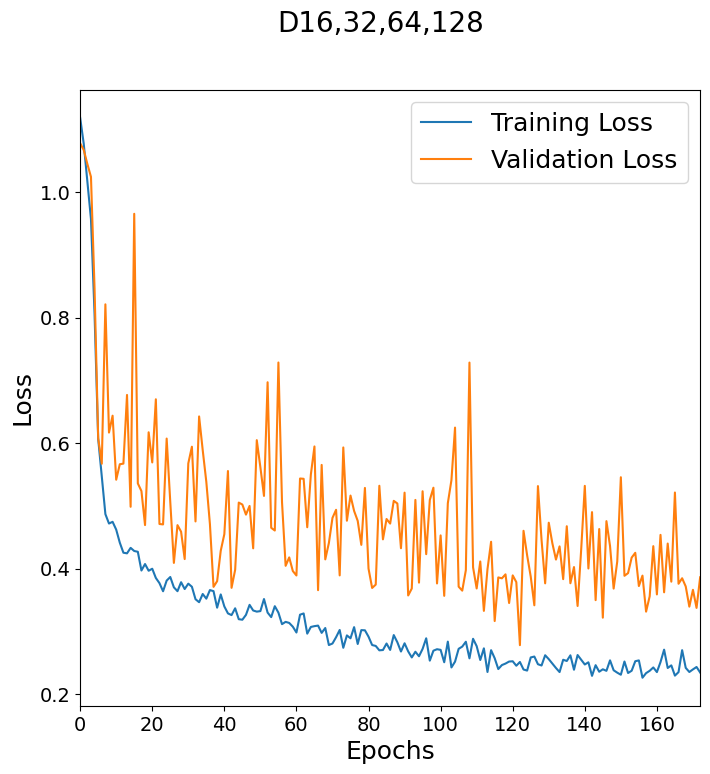

In [8]:
# Plot training accuracy
plt.figure(figsize=(8, 8))

# Vykreslenie presnosti na trénovacej a validačnej množine
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Rozsahy osí
plt.xlim([0, history.epoch[-1]])
plt.ylim([0.3, 1])

# Legenda v pravom dolnom rohu
plt.legend(loc='lower right', fontsize=18)

# Nadpis nad obrázkom
plt.suptitle('D16,32,64,128', fontsize=20)

# Uloženie grafu
plt.savefig('training_accuracy_D16_32_64_128.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training loss
plt.figure(figsize=(8, 8))

# Vykreslenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Orezanie osí podľa potreby
plt.xlim([0, history.epoch[-1]])

# Legenda hore vpravo
plt.legend(loc='upper right', fontsize=18)

# Nadpis nad grafom
plt.suptitle('D16,32,64,128', fontsize=20)

# Uloženie grafu
plt.savefig('training_loss_D16_32_64_128.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Vyhodnotenie modelu.
model = tf.keras.models.load_model(model_filename)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Vypocitanie zakladnych metrik pre vyhodnotenie.
cr7 = classification_report(np.argmax(y_test, axis=1), y_pred)
print('Classification Report\n', cr7)

# Vytvorenie matice zamen.
cm7 = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print('Confusion matrix:\n', cm7)

26/26 [==============================] - 0s 15ms/step - loss: 0.2862 - accuracy: 0.9073
Test accuracy: 0.9073405265808105
26/26 [==============================] - 0s 7ms/step
Classification Report
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       247
           1       0.92      0.79      0.85       273
           2       0.85      0.98      0.91       311

    accuracy                           0.91       831
   macro avg       0.92      0.91      0.91       831
weighted avg       0.91      0.91      0.91       831

Confusion matrix:
 [[235  11   1]
 [  4 215  54]
 [  0   7 304]]


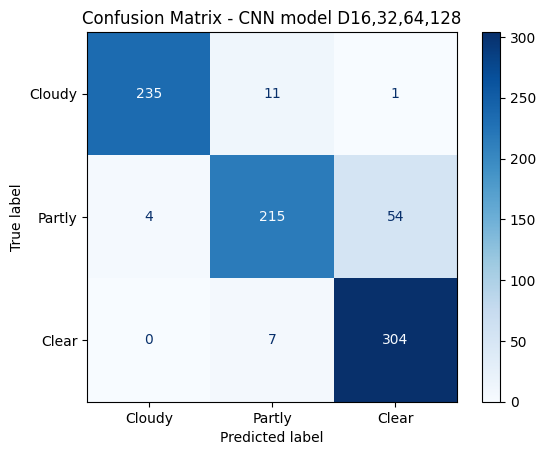

In [10]:
# Vykreslenie a ulozenie matice zamen.
cmd7 = ConfusionMatrixDisplay(cm7, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd7.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - CNN model D16,32,64,128")
plt.savefig("confusion_matrix_CNN model_D16,32,64,128.png", dpi=300, bbox_inches='tight')

plt.show()

In [11]:
# Vypisanie architektúry modelu.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

In [12]:
BATCH_SIZE = 64 # Nove nastavenie velkosti batchu.
EPOCHS = 300    # Opakovane nastavenie poctu epoch - nie je potrebne.

In [13]:
# Architektura modelu E32,64,128.
model_filename = 'E32,64,128.keras'
callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

print('Defining model...')

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Defining model...


In [14]:
# Spustenie trenovania a ukladanie historie trenovania.
print('Training model...')
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=[callback_checkpoint, early_stopping])


Training model...
Epoch 1/300
47/47 [==============================] - ETA: 0s - loss: 1.4742 - accuracy: 0.4053
Epoch 1: val_loss improved from inf to 1.07578, saving model to E32,64,128.keras
47/47 [==============================] - 7s 131ms/step - loss: 1.4742 - accuracy: 0.4053 - val_loss: 1.0758 - val_accuracy: 0.4144
Epoch 2/300
47/47 [==============================] - ETA: 0s - loss: 1.0827 - accuracy: 0.4240
Epoch 2: val_loss did not improve from 1.07578
47/47 [==============================] - 5s 107ms/step - loss: 1.0827 - accuracy: 0.4240 - val_loss: 1.0817 - val_accuracy: 0.4144
Epoch 3/300
47/47 [==============================] - ETA: 0s - loss: 1.0724 - accuracy: 0.4224
Epoch 3: val_loss did not improve from 1.07578
47/47 [==============================] - 5s 103ms/step - loss: 1.0724 - accuracy: 0.4224 - val_loss: 1.0781 - val_accuracy: 0.4144
Epoch 4/300
47/47 [==============================] - ETA: 0s - loss: 1.0232 - accuracy: 0.4632
Epoch 4: val_loss did not improve 

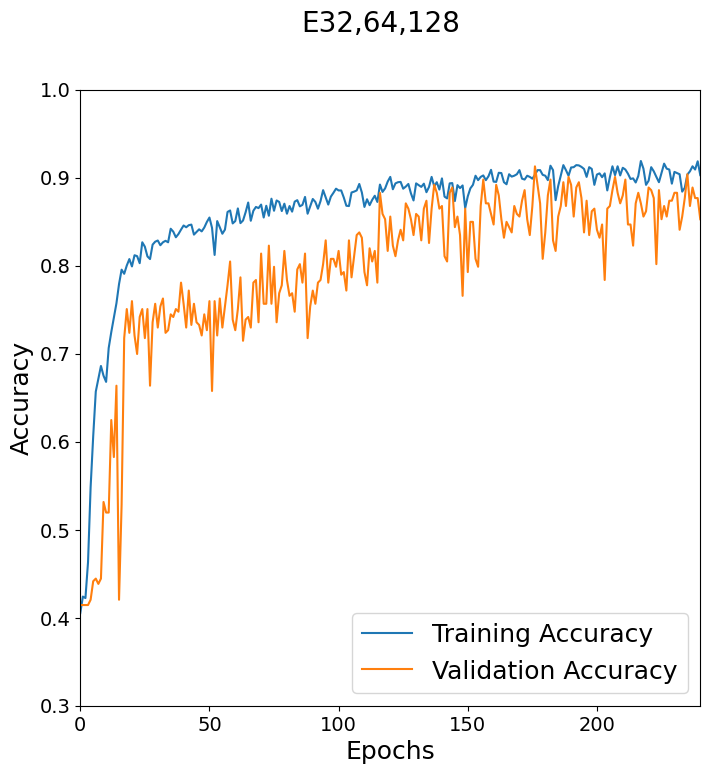

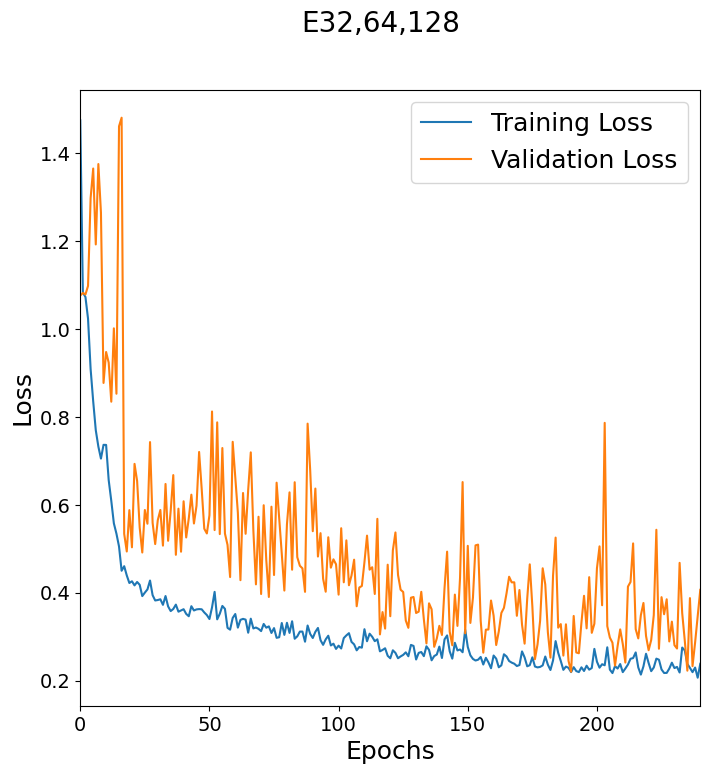

In [15]:
# Plot training accuracy
plt.figure(figsize=(8, 8))

# Vykreslenie presnosti na trénovacej a validačnej množine
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Rozsahy osí
plt.xlim([0, history.epoch[-1]])
plt.ylim([0.3, 1])

# Legenda v pravom dolnom rohu
plt.legend(loc='lower right', fontsize=18)

# Nadpis nad obrázkom
plt.suptitle('E32,64,128', fontsize=20)

# Uloženie grafu
plt.savefig('training_accuracy_E32_64_128.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training loss
plt.figure(figsize=(8, 8))

# Vykreslenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Orezanie osí podľa potreby
plt.xlim([0, history.epoch[-1]])

# Legenda hore vpravo
plt.legend(loc='upper right', fontsize=18)

# Nadpis nad grafom
plt.suptitle('E32,64,128', fontsize=20)

# Uloženie grafu
plt.savefig('training_loss_E32_64_128.png', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
# Vyhodnotenie modelu.
model = tf.keras.models.load_model(model_filename)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Vypocitanie zakladnych metrik pre vyhodnotenie.
cr8 = classification_report(np.argmax(y_test, axis=1), y_pred)
print('Classification Report\n', cr8)

# Vytvorenie matice zamen.
cm8 = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print('Confusion matrix:\n', cm8)

26/26 [==============================] - 1s 18ms/step - loss: 0.2683 - accuracy: 0.8953
Test accuracy: 0.8953068852424622
26/26 [==============================] - 0s 11ms/step
Classification Report
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       247
           1       0.88      0.79      0.83       273
           2       0.86      0.94      0.90       311

    accuracy                           0.90       831
   macro avg       0.90      0.90      0.90       831
weighted avg       0.90      0.90      0.89       831

Confusion matrix:
 [[238   9   0]
 [ 11 215  47]
 [  0  20 291]]


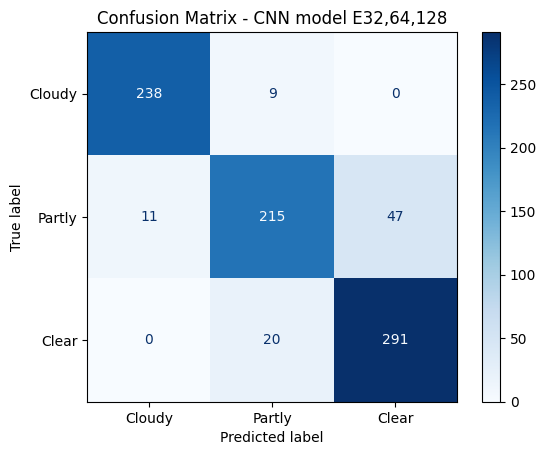

In [17]:
#vykreslenie a ulozenie matice zamien
cmd8 = ConfusionMatrixDisplay(cm8, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd8.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - CNN model E32,64,128")
plt.savefig("confusion_matrix_CNN model_E32,64,128.png", dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# Vypisanie architektúry modelu.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 62, 62, 64)       

In [11]:
# Architektura modelu Z32,64,128 s attention vrstvou.

EPOCHS = 300 # Opatovne nastavenie poctu epoch na 300 - (nie je potrebne)

model_filename = 'Z32,64,128.keras'
callback_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
# Definícia modelu s attention mechanizmom
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)

# Attention mechanizmus
attention_weights = layers.Conv2D(128, (1, 1), activation='sigmoid')(x)
x = layers.Multiply()([x, attention_weights])

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
# Spustenie trenovania a ukladanie historie trenovania.
print('Training model...')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=[callback_checkpoint, early_stopping])


Training model...
Epoch 1/300
94/94 [==============================] - ETA: 0s - loss: 1.1010 - accuracy: 0.4197
Epoch 1: val_loss improved from inf to 1.07177, saving model to Z32,64,128.keras
94/94 [==============================] - 6s 59ms/step - loss: 1.1010 - accuracy: 0.4197 - val_loss: 1.0718 - val_accuracy: 0.4144
Epoch 2/300
93/94 [============================>.] - ETA: 0s - loss: 1.0721 - accuracy: 0.4286
Epoch 2: val_loss improved from 1.07177 to 1.05671, saving model to Z32,64,128.keras
94/94 [==============================] - 5s 57ms/step - loss: 1.0721 - accuracy: 0.4287 - val_loss: 1.0567 - val_accuracy: 0.4264
Epoch 3/300
94/94 [==============================] - ETA: 0s - loss: 0.9147 - accuracy: 0.5395
Epoch 3: val_loss improved from 1.05671 to 0.95309, saving model to Z32,64,128.keras
94/94 [==============================] - 5s 57ms/step - loss: 0.9147 - accuracy: 0.5395 - val_loss: 0.9531 - val_accuracy: 0.5616
Epoch 4/300
94/94 [==============================] - ETA

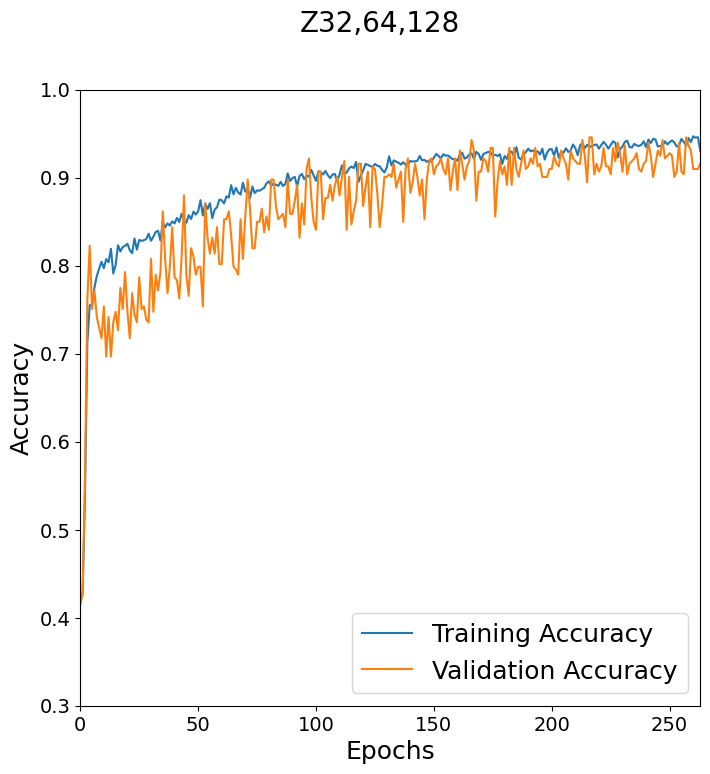

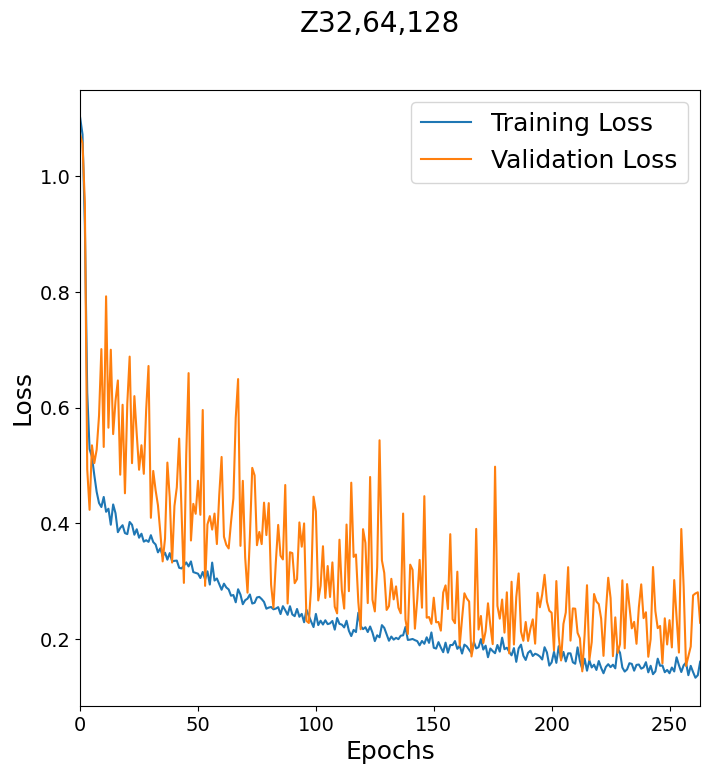

In [13]:
# Plot training accuracy
plt.figure(figsize=(8, 8))

# Vykreslenie presnosti na trénovacej a validačnej množine
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Rozsahy osí
plt.xlim([0, history.epoch[-1]])
plt.ylim([0.3, 1])

# Legenda v pravom dolnom rohu
plt.legend(loc='lower right', fontsize=18)

# Nadpis nad obrázkom
plt.suptitle('Z32,64,128', fontsize=20)

# Uloženie grafu
plt.savefig('training_accuracy_Z32_64_128.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training loss
plt.figure(figsize=(8, 8))

# Vykreslenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Popisy osí
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Orezanie osí podľa potreby
plt.xlim([0, history.epoch[-1]])

# Legenda hore vpravo
plt.legend(loc='upper right', fontsize=18)

# Nadpis nad grafom
plt.suptitle('Z32,64,128', fontsize=20)

# Uloženie grafu
plt.savefig('training_loss_Z32_64_128.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Vyhodnotenie modelu.
model = tf.keras.models.load_model(model_filename)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Vypocitanie zakladnych metrik pre vyhodnotenie.
cr9 = classification_report(np.argmax(y_test, axis=1), y_pred)
print('Classification Report\n', cr9)

# Vytvorenie matice zamen.
cm9 = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print('Confusion matrix:\n', cm9)

26/26 [==============================] - 1s 16ms/step - loss: 0.2395 - accuracy: 0.9170
Test accuracy: 0.916967511177063
26/26 [==============================] - 0s 8ms/step
Classification Report
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       247
           1       0.90      0.84      0.87       273
           2       0.87      0.94      0.90       311

    accuracy                           0.92       831
   macro avg       0.92      0.92      0.92       831
weighted avg       0.92      0.92      0.92       831

Confusion matrix:
 [[241   6   0]
 [  0 230  43]
 [  0  20 291]]


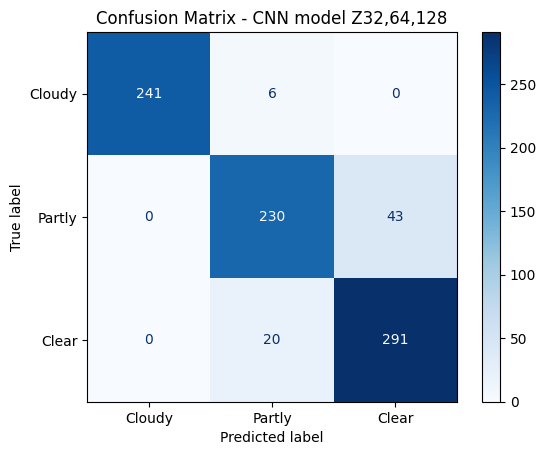

In [15]:
# Vykreslenie a ulozenie matice zamen.
cmd9 = ConfusionMatrixDisplay(cm9, display_labels=['Cloudy', 'Partly', 'Clear'])
cmd9.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix - CNN model Z32,64,128")
plt.savefig("confusion_matrix_CNN model_Z32,64,128.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Vykreslenie nespravne klasifikovanych obrazkov v 2 variantach, farebne a ciernobielo. 
nn=0
y_true = np.argmax(y_test, axis=1)

for i in range(0, len(y_pred)):
    if y_pred[i] != y_true[i]:
        im = X_test[i]
      
        plt.figure(figsize=(8, 4))  
        plt.subplot(1, 2, 1)  
        plt.imshow(im.squeeze())  
        plt.axis('off')  
        plt.title(f'Img: {nn}, True label: {y_true[i]}, Pred: {y_pred[i]}')

        plt.subplot(1, 2, 2)  
        plt.imshow(im.squeeze(), cmap='gray')  
        plt.axis('off') 
        plt.title(f'Img: {nn}, True label: {y_true[i]}, Pred: {y_pred[i]}')

        nn = nn + 1
        plt.tight_layout()  
        plt.show()

## Kedze vykreslenie tychto obrazkov zvacsuje velkost finalneho .ipynb suboru, zmazal som output lebo na github je mozne nahrat subory maximalnej velkosti 25MB.

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 128, 128, 32  0          ['conv2d_4[0][0]']               
                                )                                                           